# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Dataset

SOURCE https://www.kaggle.com/datasets/bhanupratapbiswas/uber-data-analysis

## Importing Data

In [2]:
df = pd.read_csv('Dataset/UberDataset.csv')
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


## Data Wrangling

In [4]:
# There is a problem with the data. 
# The last row is not a valid row. It is a total row. We need to remove it.

df.tail()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
1151,12/31/2016 13:24,12/31/2016 13:42,Business,Kar?chi,Unknown Location,3.9,Temporary Site
1152,12/31/2016 15:03,12/31/2016 15:38,Business,Unknown Location,Unknown Location,16.2,Meeting
1153,12/31/2016 21:32,12/31/2016 21:50,Business,Katunayake,Gampaha,6.4,Temporary Site
1154,12/31/2016 22:08,12/31/2016 23:51,Business,Gampaha,Ilukwatta,48.2,Temporary Site
1155,Totals,NaN,NaN,NaN,NaN,12204.7,NaN


In [5]:
# Removing the unnecessary row

df.drop(index=1155, axis=0, inplace=True)

In [6]:
# Checking the data

df.tail()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
1150,12/31/2016 1:07,12/31/2016 1:14,Business,Kar?chi,Kar?chi,0.7,Meeting
1151,12/31/2016 13:24,12/31/2016 13:42,Business,Kar?chi,Unknown Location,3.9,Temporary Site
1152,12/31/2016 15:03,12/31/2016 15:38,Business,Unknown Location,Unknown Location,16.2,Meeting
1153,12/31/2016 21:32,12/31/2016 21:50,Business,Katunayake,Gampaha,6.4,Temporary Site
1154,12/31/2016 22:08,12/31/2016 23:51,Business,Gampaha,Ilukwatta,48.2,Temporary Site


In [7]:
# The PURPOSE Column is too dirty since there is lots of missing values
# I will fill the missing values with 'Not Mentioned', since there is no way to know the purpose of the rides
# It would be such a waste if we drop the whole column, since it might contains valuable insight about the customers

df['PURPOSE'] = df['PURPOSE'].fillna('Not Mentioned')


In [8]:
# We want to change the DATE column from object into a datetime object
df.START_DATE = pd.to_datetime(df.START_DATE)
df.END_DATE = pd.to_datetime(df.END_DATE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1155 non-null   datetime64[ns]
 1   END_DATE    1155 non-null   datetime64[ns]
 2   CATEGORY    1155 non-null   object        
 3   START       1155 non-null   object        
 4   STOP        1155 non-null   object        
 5   MILES       1155 non-null   float64       
 6   PURPOSE     1155 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 63.3+ KB


In [9]:
# I want to get MONTH and change the format to become its full name
df['MONTH'] = df['START_DATE'].dt.strftime('%B')
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,MONTH
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,January
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Not Mentioned,January
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,January
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,January
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,January


In [10]:
# I want to bin the time periods into 4 bins with each bin having 6 hours
# Late Night: 12am - 6am
# Morning: 6am - 12pm
# Afternoon: 12pm - 6pm
# Evening: 6pm - 12am

def bin_time(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['TIME_BIN'] = df['START_DATE'].dt.hour.apply(bin_time)
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,MONTH,TIME_BIN
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,January,Evening
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Not Mentioned,January,Late Night
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,January,Evening
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,January,Afternoon
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,January,Afternoon


In [11]:
df['DURATION'] = (df['END_DATE']-df['START_DATE']).dt.total_seconds()/60

In [12]:
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,MONTH,TIME_BIN,DURATION
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,January,Evening,6.0
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Not Mentioned,January,Late Night,12.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,January,Evening,13.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,January,Afternoon,14.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,January,Afternoon,67.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1155 non-null   datetime64[ns]
 1   END_DATE    1155 non-null   datetime64[ns]
 2   CATEGORY    1155 non-null   object        
 3   START       1155 non-null   object        
 4   STOP        1155 non-null   object        
 5   MILES       1155 non-null   float64       
 6   PURPOSE     1155 non-null   object        
 7   MONTH       1155 non-null   object        
 8   TIME_BIN    1155 non-null   object        
 9   DURATION    1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 90.4+ KB


In [14]:
# Save the Clean and Processed data into a CSV file
# So we can use it in BI Tools

# df.to_csv('Dataset/UberFixDataset.csv', index=False)

In [15]:
# CHECKING NULL VALUES
df.isnull().sum()

START_DATE    0
END_DATE      0
CATEGORY      0
START         0
STOP          0
MILES         0
PURPOSE       0
MONTH         0
TIME_BIN      0
DURATION      0
dtype: int64

# EDA

In [16]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1155 non-null   datetime64[ns]
 1   END_DATE    1155 non-null   datetime64[ns]
 2   CATEGORY    1155 non-null   object        
 3   START       1155 non-null   object        
 4   STOP        1155 non-null   object        
 5   MILES       1155 non-null   float64       
 6   PURPOSE     1155 non-null   object        
 7   MONTH       1155 non-null   object        
 8   TIME_BIN    1155 non-null   object        
 9   DURATION    1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 90.4+ KB
None


,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,MONTH,TIME_BIN,DURATION
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,January,Evening,6.0
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Not Mentioned,January,Late Night,12.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,January,Evening,13.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,January,Afternoon,14.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,January,Afternoon,67.0


In [17]:
df.CATEGORY.value_counts()

Business    1078
Personal      77
Name: CATEGORY, dtype: int64

Looking for the distribution of PURPOSE column

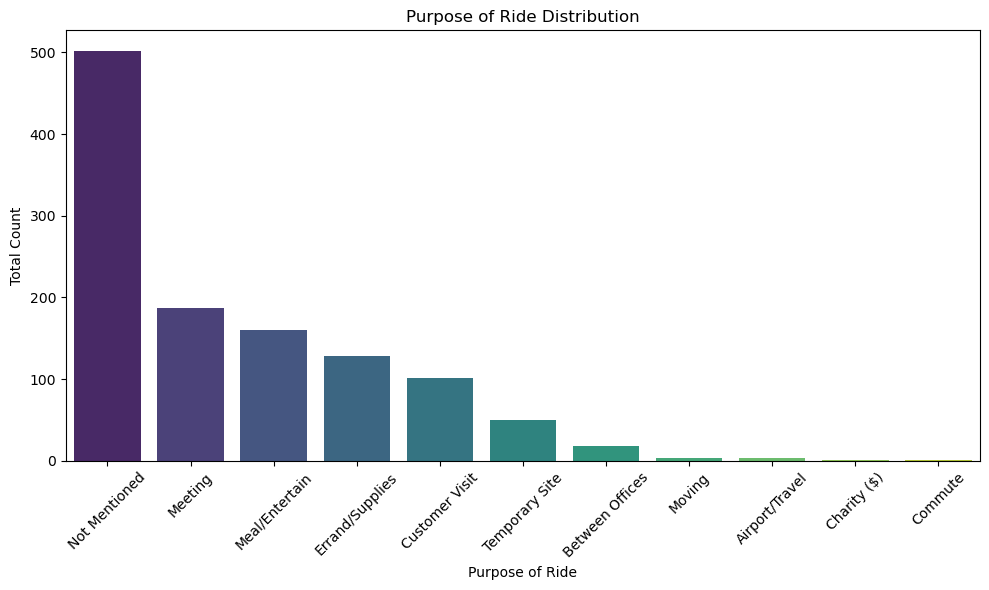

In [18]:
pur_data = df.PURPOSE.value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=pur_data.index
            , y=pur_data
            , palette='viridis'
            , order=pur_data.index
            )
plt.xticks(rotation=45)
plt.ylabel('Total Count')
plt.xlabel('Purpose of Ride')
plt.title('Purpose of Ride Distribution')
plt.tight_layout()
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1155 non-null   datetime64[ns]
 1   END_DATE    1155 non-null   datetime64[ns]
 2   CATEGORY    1155 non-null   object        
 3   START       1155 non-null   object        
 4   STOP        1155 non-null   object        
 5   MILES       1155 non-null   float64       
 6   PURPOSE     1155 non-null   object        
 7   MONTH       1155 non-null   object        
 8   TIME_BIN    1155 non-null   object        
 9   DURATION    1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 90.4+ KB


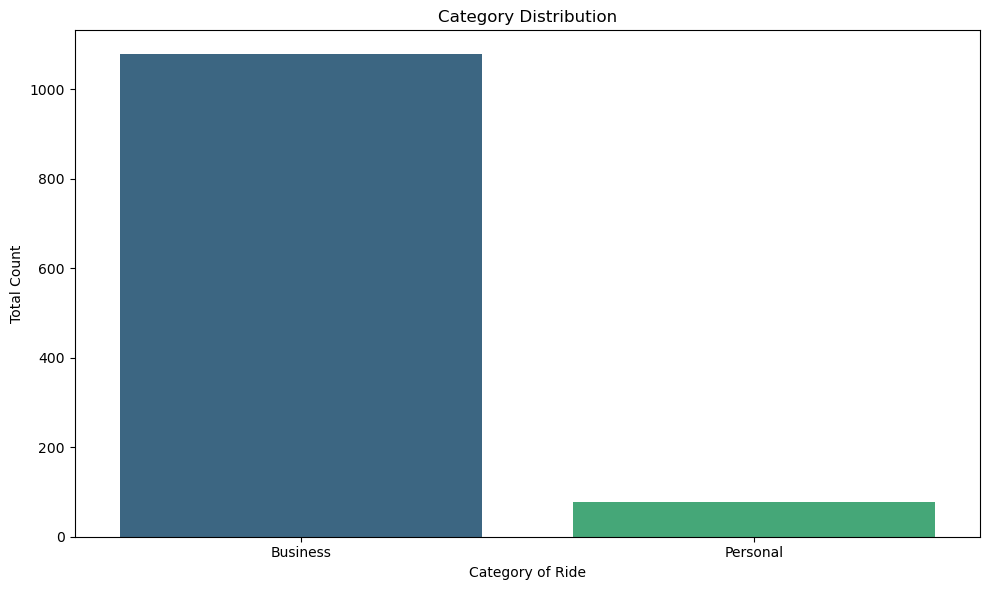

In [20]:
cat_data = df.CATEGORY.value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=cat_data.index
            , y=cat_data
            , palette="viridis"
            )
#plt.xticks(rotation=45)
plt.ylabel('Total Count')
plt.xlabel('Category of Ride')
plt.title('Category Distribution')
plt.tight_layout()
plt.show()

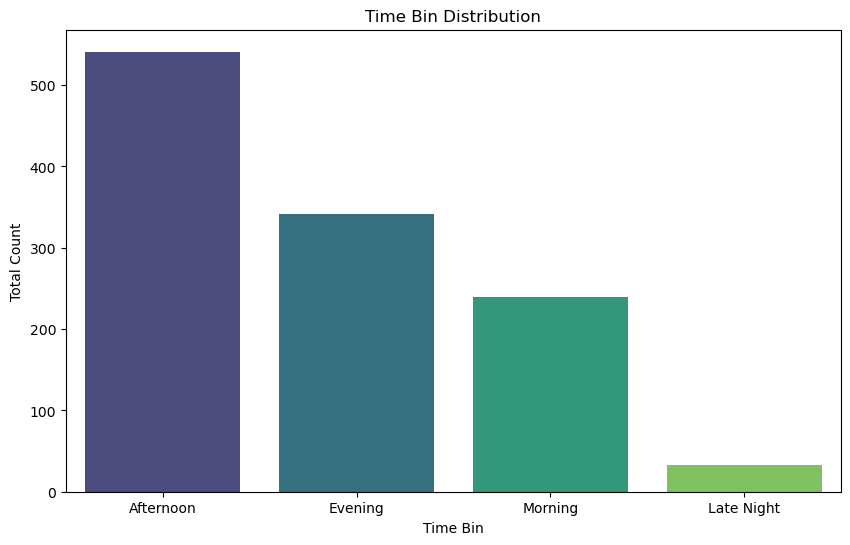

In [21]:
time_bin_data = df.TIME_BIN.value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=time_bin_data.index
            , y=time_bin_data.values
            , palette='viridis'
            )
plt.xlabel('Time Bin')
plt.ylabel('Total Count')
plt.title('Time Bin Distribution')
plt.show()


In [22]:
df.groupby(['PURPOSE']).mean().sort_values(by='MILES', ascending=False)

# Notice that Commute has abnormal average miles, so we need to explore it more

,MILES,DURATION
PURPOSE,,
Commute,180.200000,185.000000
Customer Visit,20.688119,33.415842
Meeting,15.247594,29.737968
Charity ($),15.100000,27.000000
Between Offices,10.944444,25.500000
Temporary Site,10.474000,25.860000
Not Mentioned,9.748008,23.041833
Meal/Entertain,5.698125,16.125000
Airport/Travel,5.500000,26.000000


In [23]:
commute_miles = pysqldf(
    """
    SELECT
        PURPOSE
        , TIME_BIN
        , MILES
    FROM
        df
     WHERE
         PURPOSE = 'Commute'
    """
)

commute_miles

,PURPOSE,TIME_BIN,MILES
0,Commute,Afternoon,180.2


In [24]:
# We notice that there is only one rows with purpose = Commute, so we can say that this is an outlier
# We can remove this row from the dataset if we want to do ML on this dataset
# But since this is a small dataset and we do not plan to do ML, we can keep it as it is

df[df['PURPOSE'] == 'Commute']

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,MONTH,TIME_BIN,DURATION
559,2016-07-17 12:20:00,2016-07-17 15:25:00,Personal,Boone,Cary,180.2,Commute,July,Afternoon,185.0


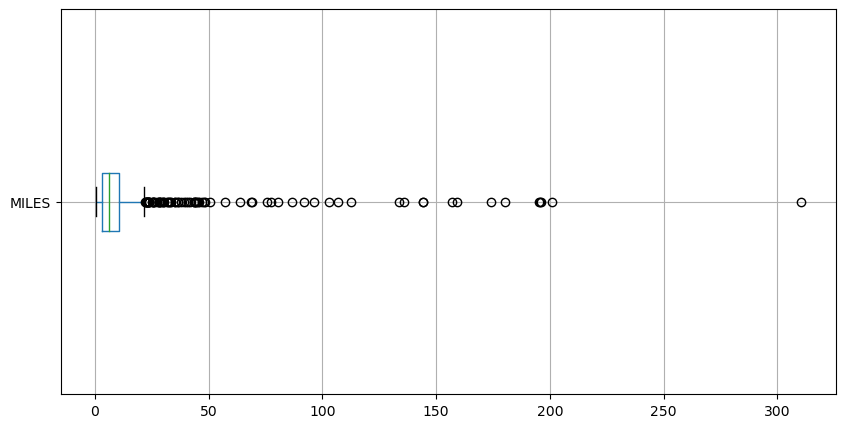

In [25]:
# Since we were looking for outlier, might as well look into the whole dataset and we can see that there is a lots of outlier in the MILES column.
df.boxplot(column=['MILES'], vert=False, figsize=(10, 5))
plt.show()


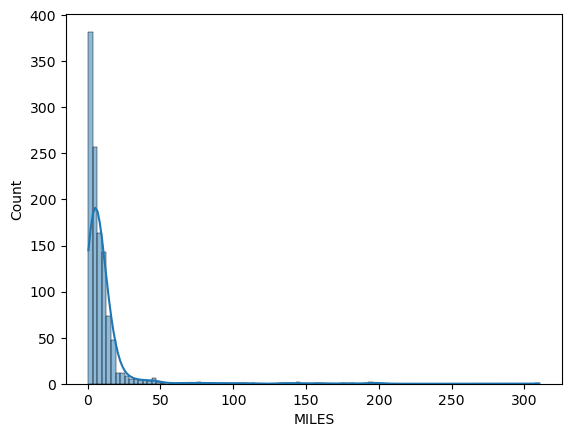

In [26]:
sns.histplot(data = df, x = 'MILES', kde = True,bins = 100)
plt.show()

We notice that most of the rides is lesser than *50 Miles*


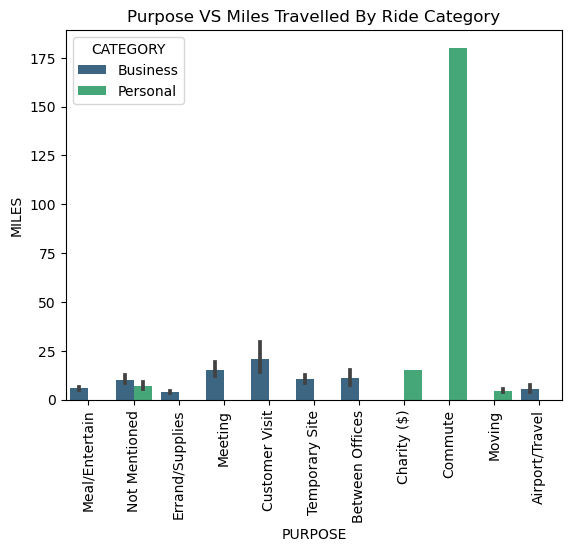

In [27]:
# Now we need to find what kind of trips that most customer use Uber for

sns.barplot(x= df["PURPOSE"]
, y= df['MILES']
, hue = df["CATEGORY"]
, palette='viridis')


plt.title("Purpose VS Miles Travelled By Ride Category")
plt.xticks(rotation=90)
plt.show()

We can see that most of our customer use our service to commute on the PERSONAL Category, but we need to remember that this PURPOSE is an outlier in this dataset

In [28]:
df.describe()

,MILES,DURATION
count,1155.000000,1155.000000
mean,10.566840,23.243290
std,21.579106,27.318277
min,0.500000,0.000000
25%,2.900000,10.000000
50%,6.000000,16.000000
75%,10.400000,27.500000
max,310.300000,336.000000


And we can confirm that most of the rides is averaging on 10.56 Miles and 23.24 Minutes Durations

In [29]:
df.MILES.count()

1155

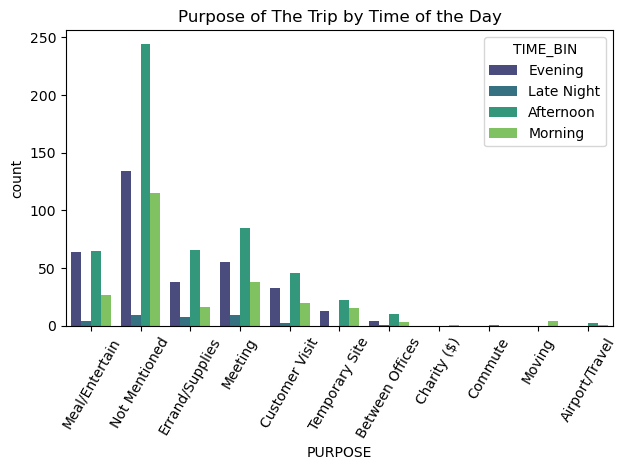

In [30]:
sns.countplot(x='PURPOSE'
              ,hue='TIME_BIN'
              , data=df
              , palette='viridis'
              )

plt.title('Purpose of The Trip by Time of the Day')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

From the graph above, we can see that most of the trips took place at Morning, Afernoon, and Evening.
We can use this information to make decision. Such as:
- **When to create ads campaign**
- **What kind of customer segmentation that can be available for certain discount**, such as customer who use Uber to do their Errand or Supplies
- **Tells Uber Drivers when is the hottest hours**

But, since we know that lots of entity doesnt mention their trip purposes, we also need to dig deeper. We can start at looking for the CATEGORY column

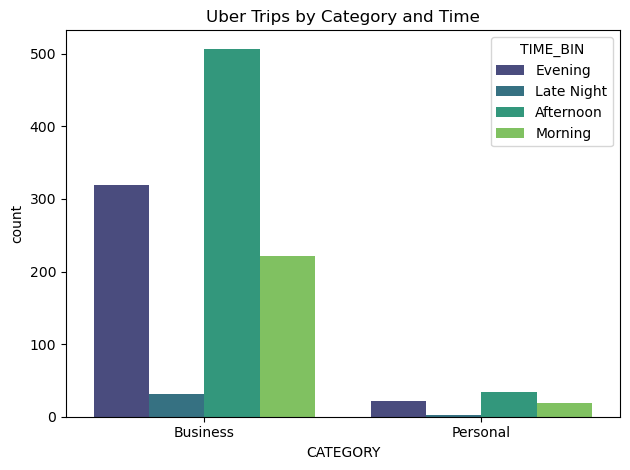

In [31]:
sns.countplot(x='CATEGORY'
              ,hue='TIME_BIN'
              , data=df
              , palette='viridis'
              )


plt.title('Uber Trips by Category and Time')
plt.tight_layout()
plt.show()

We can see that the pattern is still the same

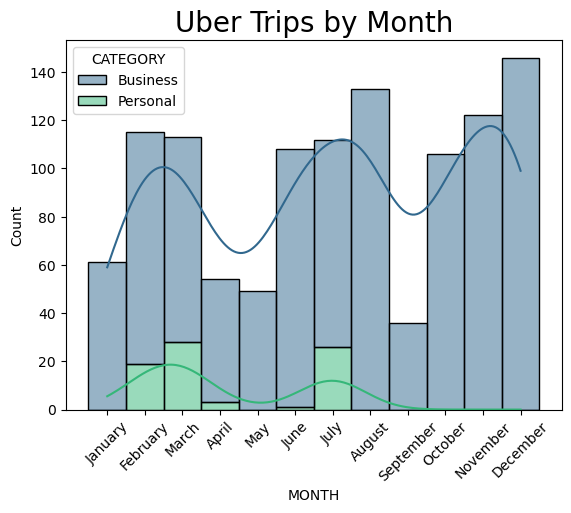

In [32]:
sns.histplot(data = df, x = 'MONTH', kde = True, hue = 'CATEGORY', multiple = 'stack', palette = 'viridis')
plt.xticks(rotation = 45)

plt.title('Uber Trips by Month', fontsize = 20)
plt.show()

We can tell that there is some peak during few Months
- February-March
- June-August
- October-December

And some dips during
- April - May
- September

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1155 non-null   datetime64[ns]
 1   END_DATE    1155 non-null   datetime64[ns]
 2   CATEGORY    1155 non-null   object        
 3   START       1155 non-null   object        
 4   STOP        1155 non-null   object        
 5   MILES       1155 non-null   float64       
 6   PURPOSE     1155 non-null   object        
 7   MONTH       1155 non-null   object        
 8   TIME_BIN    1155 non-null   object        
 9   DURATION    1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 90.4+ KB


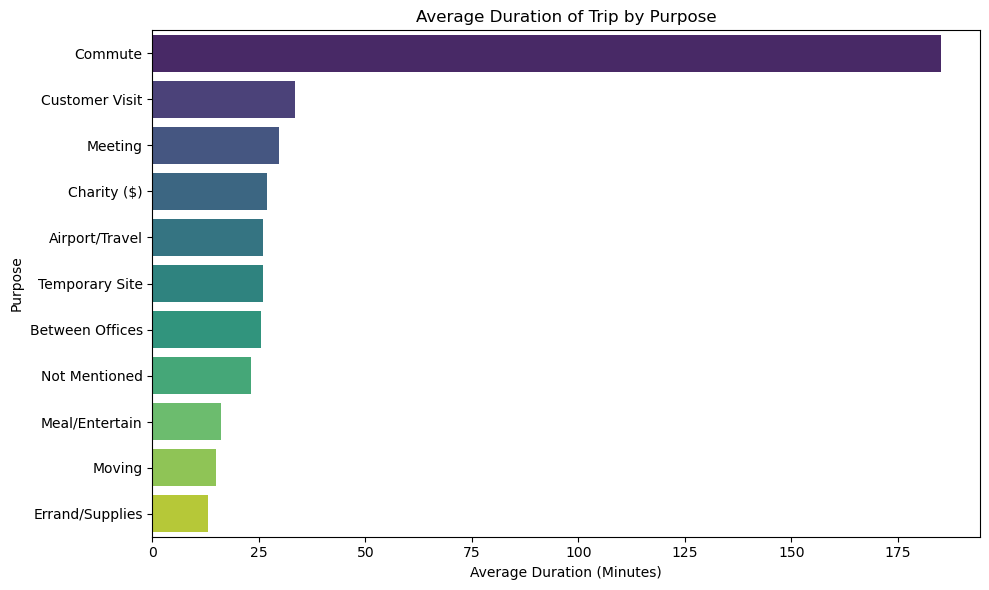

In [34]:
avg_dur_pur = pysqldf(
    """
    SELECT
        PURPOSE,
        ROUND(AVG(DURATION),2) AS AVG_DURATION
    FROM
        df
    GROUP BY
        PURPOSE
    ORDER BY
        AVG_DURATION DESC

    """
)

plt.figure(figsize=(10,6))
sns.barplot(x='AVG_DURATION'
            , y='PURPOSE'
            , data=avg_dur_pur
            , palette='viridis'
            )

plt.title('Average Duration of Trip by Purpose')
plt.xlabel('Average Duration (Minutes)')
plt.ylabel('Purpose')

plt.tight_layout()
plt.show()


PURPOSE
Commute            180.200000
Customer Visit      20.688119
Meeting             15.247594
Charity ($)         15.100000
Between Offices     10.944444
Temporary Site      10.474000
Not Mentioned        9.748008
Meal/Entertain       5.698125
Airport/Travel       5.500000
Moving               4.550000
Errand/Supplies      3.968750
Name: MILES, dtype: float64

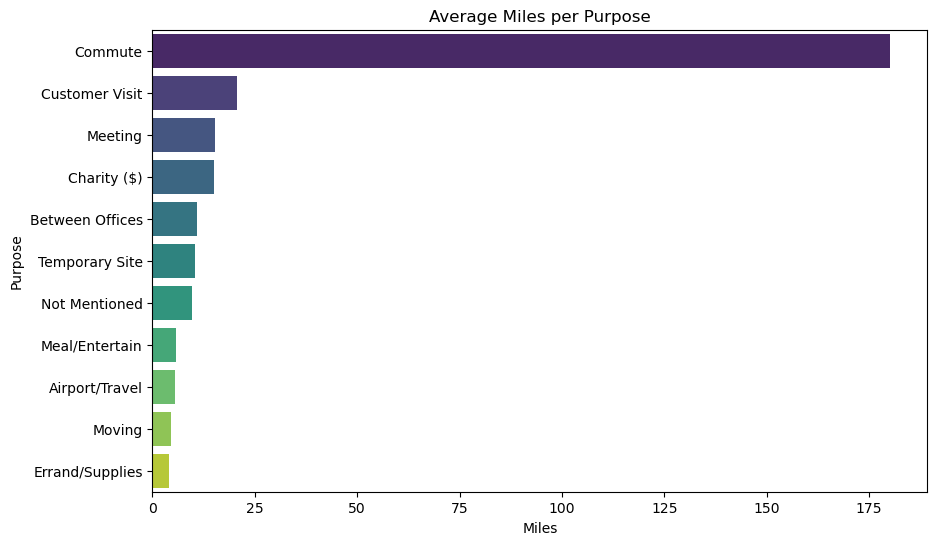

In [41]:
avg_mile_dur = df.groupby('PURPOSE')['MILES'].mean().sort_values(ascending=False)
display(avg_mile_dur)


plt.figure(figsize=(10,6))
sns.barplot(x=avg_mile_dur.values
    , y=avg_mile_dur.index
    , palette='viridis')

plt.title('Average Miles per Purpose')
plt.xlabel('Miles')
plt.ylabel('Purpose')

plt.show()

CATEGORY
Business    10.655844
Personal     9.320779
Name: MILES, dtype: float64

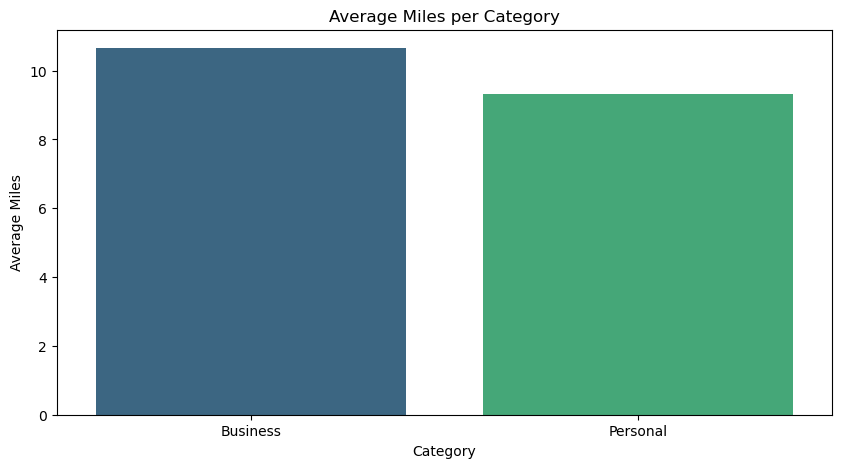

In [40]:
avg_mile_cat = df.groupby('CATEGORY')['MILES'].mean().sort_values(ascending=False)
display(avg_mile_cat)

plt.figure(figsize=(10,5))
sns.barplot(x=avg_mile_cat.index
    , y=avg_mile_cat.values
    , palette='viridis')
plt.title('Average Miles per Category')
plt.xlabel('Category')
plt.ylabel('Average Miles')
plt.show()




,CATEGORY,AVG_DURATION
0,Business,23.44
1,Personal,20.45


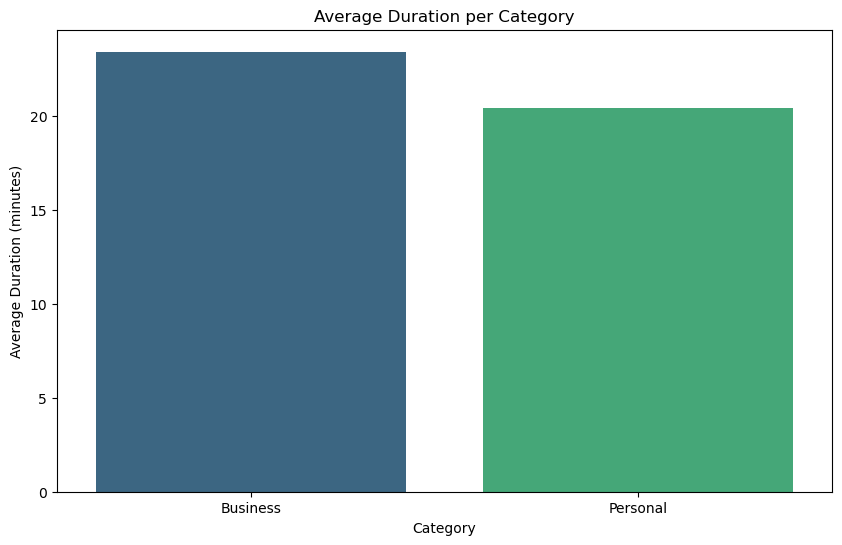

In [39]:
avg_dur_cat = pysqldf(
    """
        SELECT
            CATEGORY
            , ROUND(AVG(DURATION), 2) AS AVG_DURATION
        FROM
            df
        GROUP BY
            CATEGORY
        ORDER BY
            AVG_DURATION DESC
    """
)

display(avg_dur_cat)

plt.figure(figsize=(10,6))
sns.barplot(x='CATEGORY'
            , y='AVG_DURATION'
            , data=avg_dur_cat
            , palette='viridis'
            )

plt.title('Average Duration per Category')
plt.xlabel('Category')
plt.ylabel('Average Duration (minutes)')
#plt.xticks(rotation=45)
plt.show()

# Conclusion and Insight

After analyzing the whole dataset, we can learn some insight:

We know that most of the trips is taken during the Morning till Evening, which make sense since this dataset mostly used by Business account that obviously taking a ride during work hours.

We can use this information to make decision. Such as:
- **When to create ads campaign**
- **What kind of customer segmentation that can be available for certain discount**, such as customer who use Uber to do their Errand or Supplies
- **Tells Uber Drivers when is the hottest hours,** the more drivers available, the more trips will be taken

However we can tell that the average miles of the trips is **10.56 miles**.

This information might be useful to create some strategy or tactic such as:
- How to incentivizes longer trips
- Giving discount or other incentives depending on their trip miles
- Adding more service for either the longer or shorter trip

We can tell that there is some peak during few Months
- February-March
- June-August
- October-December

And some dips during
- April - May
- September

We can use this information to create a strategy to either boost or maintain performances during certain month, such as:
- Create more ads, discount, or incentives during rain, hot day, snow, etc. or by the information given above
- We can analyze more during the "dips" month to know what causing the losing performances
